In [1]:
 from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# function ClickConnect (){
#     console.log("Clicked on connect button")
#     document.querySelector("colab-connect-button").click()    
# }

# setInterval(ClickConnect,60000)

In [3]:
!pip3 install mne
!pip3 install pyprep
!pip3 install autoreject
!pip3 install h5io
!pip3 install pymatreader
!pip3 install pyhht
!pip3 install tftb
%matplotlib inline

     |████████████████████████████████| 7.7 MB 5.1 MB/s 
  Created wheel for mne: filename=mne-1.0.1-py3-none-any.whl size=7542700 sha256=c7b9d1e2d74e936ee2206a688c4aa6fa784ff7ffa387d41c173e7908a66656de
  Stored in directory: /root/.cache/pip/wheels/b1/16/e2/46ea7fb2215890e506fa85526ccbc2145663ad12c356d04c35
Successfully built mne
  Created wheel for tftb: filename=tftb-0.1.3-py3-none-any.whl size=54999 sha256=16ddb72d0007a019276f41d4adb566be9dd6b718c038d09555438cf355df1cd3
  Stored in directory: /root/.cache/pip/wheels/3c/6c/40/d9339347021b49fda0cccb03815597efd6ef3e91dc89842bde
Successfully built tftb


In [4]:
import os
import gc
import glob
import random
import scipy.io
import numpy as np
import pandas as pd
import seaborn as sn
import multiprocessing as mp
from tqdm import tqdm

from pymatreader import read_mat

import pyhht
import tftb.processing

from scipy import stats
from scipy.stats import special_ortho_group
from scipy import signal
from scipy.signal import decimate
from scipy.signal import hilbert
from scipy import linalg

from pyprep.prep_pipeline import PrepPipeline
from pyprep.reference import Reference

import mne
from mne import compute_raw_covariance
from mne.decoding import UnsupervisedSpatialFilter
from mne.decoding import (Vectorizer, CSP, PSDEstimator)
from mne.baseline import rescale
from mne.viz import centers_to_edges
from mne.time_frequency import tfr_array_morlet
from mne.time_frequency import morlet
from mne.preprocessing import (ICA, create_eog_epochs, create_ecg_epochs,
                               corrmap)
from mne.preprocessing import (create_eog_epochs, create_ecg_epochs,
                               compute_proj_ecg, compute_proj_eog,find_eog_events,
                               Xdawn)

from autoreject import (AutoReject, set_matplotlib_defaults)
from autoreject import Ransac  # noqa
from autoreject.utils import interpolate_bads  # noqa

import matplotlib.pyplot as plt

from ipywidgets import interact

from sklearn.decomposition import PCA, FastICA
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, StratifiedKFold
from sklearn import metrics
from sklearn.feature_selection import mutual_info_regression

#from sklearn.externals import joblib
import pickle
from joblib import dump, load

import sys
sys.path.append('/content/drive/My Drive/TG - Christian Camilo Rosero/Codigo/NL_PCA')
sys.path.append('/content/drive/My Drive/TG - Christian Camilo Rosero/Codigo/OSF_storage')
from sklearn_nlpca import NLPCA
from ica import ICA
import mutual_info
# from pyeeg import *
# from pylab import *

# **FUNCIONES**

In [5]:
def SNR_1(epochs_raw, epochs_preproc, task):
  tmin=0.0

  if task == 'per':
    tmax = 1.1  # event to 1100 ms after it
  if task == 'img':
    tmax = 3.1  # to 3100 ms after it


  evoked_raw = epochs_raw.average()
  evoked_preproc = epochs_preproc.average()

  iter_freqs = [
      ('Theta', 5, 7),
      ('Alpha', 8, 13),
      ('Low Beta', 14, 20),
      ('High Beta', 21, 31)
                 ]
  
  snr_raw_band = []
  snr_prepoc_band = []

  for band, fmin, fmax in iter_freqs:
    print('SNR '+band+' band')
    kwargs = dict(fmin=fmin, fmax=fmax+1, n_jobs=1)
    psds_welch_mean_r, _ = psd_welch(evoked_raw, **kwargs)
    psds_welch_mean_p, _ = psd_welch(evoked_preproc, **kwargs)
      
    psds_welch_raw, _ = psd_welch(epochs_raw, **kwargs)
    psds_welch_prepoc, _ = psd_welch(epochs_preproc, **kwargs)
    noise_psd_raw =  psds_welch_raw - psds_welch_mean_r
    noise_psd_prepoc =  psds_welch_prepoc - psds_welch_mean_p
  
    snr_raw = 10*np.log10(psds_welch_raw/noise_psd_raw)
    snr_prepoc = 10*np.log10(psds_welch_prepoc/noise_psd_prepoc)

    snr_raw = np.nan_to_num(snr_raw)
    snr_prepoc = np.nan_to_num(snr_prepoc)

    snr_raw = np.mean(snr_raw)
    snr_prepoc = np.mean(snr_prepoc)

    snr_raw_band.append(snr_raw)
    snr_prepoc_band.append(snr_prepoc)
  
  snr_raw_band = np.array(snr_raw_band)
  snr_prepoc_band = np.array(snr_prepoc_band)

  return snr_raw_band, snr_prepoc_band

In [6]:
# Return X and y data from Epoched Dataframe
# X: EEG data, in format Ntrials x Nchannels X Nsamples
# y: labels
def getEEGXY(df, channels, columnClass, ColumnEpoch):
  import numpy as np
  classes = df[columnClass].unique()
  X = []
  y = []
  for label in classes:
    dfClass = df[df[columnClass]==label]
    epochs = dfClass[ColumnEpoch].unique()
    for epoch in epochs:
      dfEpoch = dfClass[dfClass[ColumnEpoch]==epoch]
      y.append(label)
      X.append(np.transpose(dfEpoch[channels].values))
  return np.stack(X,axis=0), np.array(y)

In [7]:
def convolve_walevet_morlet(X, sfreq, freqs, n_cycles=7.0, t=1.0):
  #print('n_cycles'+str(n_cycles))
  sigma = (n_cycles/(2*np.pi*t))*5
  n_freqs = len(freqs)
  n_epochs, n_chans, n_times = X.shape
  dtype = np.complex128
  out = np.empty((n_epochs, n_chans, n_freqs, n_times), dtype)
  for e in range(len(out[:,:,:,:])):
    for c in range(len(out[e,:,:,:])):
      for f in range(len(out[e,c,:,:])):
        wlt = morlet(sfreq=epochs.info['sfreq'],freqs=[freqs[f]], n_cycles=n_cycles,sigma=sigma, zero_mean=True)[0]
        z = X[e,c,:]
        out[e,c,f,:] = np.convolve(z, wlt, mode='same')
        # out[e,c,f,:] = signal.convolve(z, wlt, mode='same', method='fft')
        # Plot
        # t = np.arange(wlt.size) / epochs.info['sfreq']
        # print('De '+str(t[0]) + ' a ' + str(t[-1]))
  gc.collect()
  return out

def Hilbert_Huang_transform(X, sfreq, freqs, n_cycles=7.0, t=1.0):
  #print('n_cycles'+str(n_cycles))
  sigma = (n_cycles/(2*np.pi*t))*5
  n_freqs = len(freqs)
  n_epochs, n_chans, n_times = X.shape
  dtype = np.complex128
  out = np.empty((n_epochs, n_chans, n_freqs, n_times), dtype)
  for e in range(len(out[:,:,:,:])):
    for c in range(len(out[e,:,:,:])):
      for f in range(len(out[e,c,:,:])):
        wlt = morlet(sfreq=epochs.info['sfreq'],freqs=[freqs[f]], n_cycles=n_cycles,sigma=sigma, zero_mean=True)[0]
        z = X[e,c,:]
        out[e,c,f,:] = np.convolve(z, wlt, mode='same')
        # out[e,c,f,:] = signal.convolve(z, wlt, mode='same', method='fft')
        # Plot
        # t = np.arange(wlt.size) / epochs.info['sfreq']
        # print('De '+str(t[0]) + ' a ' + str(t[-1]))
  gc.collect()
  return out

In [8]:
# X = epochs.get_data()
# DataRaw = X[0,0]
# decomposer = pyhht.emd.EMD(DataRaw)
# imfs = decomposer.decompose () #Obtiene datos imfs.
# ReImf = []
# for im in imfs[:-1]:
#   ReImf.append(hilbert(im))
# ReImf = np.array(ReImf)
# Amplitude = abs(ReImf)
# HS = Amplitude.T

# freq = []
# timepoint = []
# for im in ReImf:
#   instf, timestamps = tftb.processing.inst_freq(im)
#   freq.append(instf)
# freq = np.array(freq).T

# HS = np.reshape(HS,(1,-1))[0]
# freq = np.reshape(freq,(1,-1))[0]*100

# ftemp = []
# Atemp = []
# while len(freq) != 0:
#   indx = np.where(freq==freq[0])[0]
#   ftemp.append(freq[0])
#   Atemp.append(np.sum(HS[indx], axis=0))
#   freq[indx] = 0
#   HS[indx] = 0
#   freq = freq[np.where(freq!=0)[0]]
#   HS = HS[np.where(HS!=0)[0]]
# ftemp = np.array(ftemp)
# Atemp = np.array(Atemp)

# F = np.sort(ftemp)
# indx = np.argsort(ftemp)
# A = Atemp[indx]

In [9]:
def PREP(raw, line=50):
  # implements the functionality  of the PREP (preprocessing pipeline) for EEG data 
  print('Implements the functionality  of the PREP')
  montage = eeg_raw.get_montage()
  prep_params = {
    "ref_chs": "eeg",
    "reref_chs": "eeg",
    "line_freqs": np.arange(50, eeg_raw.info["sfreq"]/ 2, 50),
      }
  filter_kwargs = {
    "method":"spectrum_fit",
    "mt_bandwidth":2,
    "p_value":0.01,
    "filter_length":"10s"
     }
  # 1. Remove line-noise without committing to a filtering strategy.
  # 2. Robustly reference the signal relative to an estimate of the “true” average reference.
  # 3. Detect and interpolate bad channels relative to this reference.
  # 4. Retain sufficient information to allow users to re-reference using another method or 
  #    to undo interpolation of a particular channel.
  prep = PrepPipeline(eeg_raw, prep_params, montage, ransac=False)
  prep.fit()
  
  print("Number of Bad channels original before robust reference: {}".format(len(prep.noisy_channels_original["bad_all"])))
  print("Bad channels original before robust reference: {}".format(prep.noisy_channels_original["bad_all"]))
  print("Number of Bad channels after robust reference but before interpolation: {}".format(len(prep.bad_before_interpolation)))
  print("Bad channels after robust reference but before interpolation: {}".format(prep.bad_before_interpolation))
  print("Number of Interpolated channels: {}".format(len(prep.interpolated_channels)))
  print("Interpolated channels: {}".format(prep.interpolated_channels))
  print("Number of Bad channels after interpolation: {}".format(len(prep.still_noisy_channels)))
  print("Bad channels after interpolation: {}".format(prep.still_noisy_channels))

  info_prep = {'noisy_channels_original':prep.noisy_channels_original, 'bad_before_interpolation':prep.bad_before_interpolation,
               'interpolated_channels':prep.interpolated_channels, 'still_noisy_channels':prep.still_noisy_channels}

  raw = prep.raw

  raw.plot(duration=15, n_channels=len(eeg_raw.ch_names))
  # fig = eeg_raw.plot_psd(tmax=np.inf, fmax=250, average=True)
  # # add some arrows at 500 Hz and its harmonics:
  # for ax in fig.axes[1:]:
  #   freqs = ax.lines[-1].get_xdata()
  #   psds = ax.lines[-1].get_ydata()
  #   for freq in (50, 100, 150, 200, 250):
  #       idx = np.searchsorted(freqs, freq)
  #       ax.arrow(x=freqs[idx], y=psds[idx] + 18, dx=0, dy=-12, color='red',
  #                width=0.1, head_width=3, length_includes_head=True)
  
  return raw, info_prep


def Repairing_EOG_artifacts(raw, components=4, algoritme='SSP'):
  channels_EOG = ['Fp1','Fp2','AF7','AF8']
  raw_original = raw.copy() #Copy original
  
  if algoritme is 'SSP':
    #SSP ft Fp1,Fp2,AF7,AF8
    print('\nRepairing EOG artifacts with SSP')
    # eog_events = mne.preprocessing.find_eog_events(raw, ch_name= channels_EOG)
    eog_epochs = mne.preprocessing.create_eog_epochs(raw_original, baseline=None,ch_name= channels_EOG)
    eog_epochs.plot_image(combine='mean')
    eog_epochs.average().plot_joint()
    # raw.load_data().filter(l_freq=0.3, h_freq=None)
    eog_projs, _ = compute_proj_eog(raw, n_eeg=components, tmin=-0.2, tmax=0.2, reject=None, ch_name= channels_EOG, 
                                    avg_ref=False, l_freq = 0.5 , h_freq = 65.0, average = False, no_proj=True, 
                                    filter_method='iir', iir_params=dict(order=3, ftype='butter', output='sos'), n_jobs=-1)
    mne.viz.plot_projs_topomap(eog_projs, info=raw.info)

    raw.add_proj(eog_projs)
    raw.apply_proj()
    
    # Filter CAR
    raw_ssp = raw.copy() #Copy Average Reference
    raw = raw.set_eeg_reference(ref_channels='average')


    print('\n')

    ### Grafique artefactos
    eog_epochs_ssp = mne.preprocessing.create_eog_epochs(raw_ssp, baseline=None,ch_name= channels_EOG)
    eog_epochs_ssp.plot_image(combine='mean')
    print('\n')
    eog_epochs_ssp.average().plot_joint()
    print('\n')

    eog_epochs_ref = mne.preprocessing.create_eog_epochs(raw, baseline=None,ch_name= channels_EOG)
    eog_epochs_ref.plot_image(combine='mean')
    print('\n')
    eog_epochs_ref.average().plot_joint()
    print('\n')
    #############

    print('\n')
    
    fig = raw_original.plot(duration=15, n_channels=len(raw.ch_names))
    fig.subplots_adjust(top=0.9)
    fig.suptitle('{} Reference'.format('With PREP'), size='xx-large', weight='bold')
    
    fig = raw_ssp.plot(duration=15, n_channels=len(raw.ch_names))
    fig.subplots_adjust(top=0.9)
    fig.suptitle('{} Reference'.format('With EOG Project'+algoritme), size='xx-large', weight='bold')
    
    fig = raw.plot(duration=15, n_channels=len(raw.ch_names))
    fig.subplots_adjust(top=0.9)
    fig.suptitle('{} Reference'.format('With Filter CAR'), size='xx-large', weight='bold')

    del raw_original
    del raw_ssp 

    return raw

  if algoritme is 'ICA':
    #Fit ICA EOG
    print('\nRepairing EOG artifacts with ICA')
    filt_raw = raw.copy()
    filt_raw.load_data().filter(l_freq=0.3, h_freq=None)
    ica_eog = ICA(n_components=components, random_state=97)
    ica_eog.fit(filt_raw, decim=4)
    del filt_raw
    print('Without EOG Project ICA')
    raw.plot(duration=15, n_channels=len(raw.ch_names))

    #Delete EOG pattern
    ica_eog.exclude = []
    eog_indices, eog_scores = ica_eog.find_bads_eog(raw, ch_name = 'Fp1,Fp2,AF7,AF8')
    # find which ICs match the EOG pattern
    ica_eog.exclude = eog_indices
    del eog_indices, eog_scores
    ica_eog.apply(raw)
    del ica_eog
    print('With EOG Project ICA')
    raw.plot(duration=15, n_channels=len(raw.ch_names))
    return raw
  
  else:
    return raw_original

In [10]:
def extract_raw(path, subject, sesion, task, event_id):
  path_raw_file = path + 'subj' + subject + '/' + 'ses' + sesion + '/' + task + '/'

  targetPattern = path_raw_file + "*.vhdr"
  data_raw_file = glob.glob(targetPattern)
  raw = mne.io.read_raw_brainvision(data_raw_file[0], preload=True)
  print(raw)
  print(raw.info)
  channels = raw.info['ch_names']
  Fs = raw.info['sfreq']
  raw.plot(duration=15, n_channels=len(raw.ch_names))
  events, event_dict = mne.events_from_annotations(raw)
  event_dict = event_id
  fig = mne.viz.plot_events(events, event_id=event_dict, sfreq=raw.info['sfreq'],
                          first_samp=raw.first_samp)
  
  # fig = raw.plot_psd(tmax=np.inf, fmax=250, average=True)
  # # add some arrows at 50 Hz and its harmonics:
  # for ax in fig.axes[1:]:
  #   freqs = ax.lines[-1].get_xdata()
  #   psds = ax.lines[-1].get_ydata()
  #   for freq in (50, 100, 150, 200, 250):
  #       idx = np.searchsorted(freqs, freq)
  #       ax.arrow(x=freqs[idx], y=psds[idx] + 18, dx=0, dy=-12, color='red',
  #                width=0.1, head_width=3, length_includes_head=True)
        
  return raw, Fs, events

def preprocesing(raw, algoritme='SSP', components=4, sfreq=250):
  raw_original = raw.copy()
  print('Preprocesing...')
  print('Resample to %0.1f' % (sfreq) +' Hz')
  raw.resample(sfreq=sfreq)
  raw_resample = raw.copy()
  raw, info_prep = PREP(raw)
  raw_prep = raw.copy()
  raw = Repairing_EOG_artifacts(raw=raw, components=components, algoritme=algoritme)
  raw_SSP = raw.copy()

  print('PSD original')
  raw_original.plot_psd(average=True)
  print('PSD After Resample')
  raw_resample.plot_psd(average=True)
  print('PSD After PREP')
  raw_prep.plot_psd(average=True)
  print('PSD After SSP')
  raw_SSP.plot_psd(average=True)

  del raw_original, raw_resample, raw_prep, raw_SSP

  return raw, info_prep 

def extract_epochs(raw, event_dict, task, Fs=None, baseline = (-0.5, -0.3), repair=False, rejectEpoch=False):
  
  events, _ = mne.events_from_annotations(raw)
 
  if task == 'per':
    tmin, tmax = (-0.6, 1.1)  # epoch from 600 ms before event to 1100 ms after it
  if task == 'img':
    tmin, tmax = (-0.6, 3.1)  # epoch from 600 ms before event to 3100 ms after it
    #baseline = (0.3,0.5)
    
  # baseline period from start of epoch to time=0
  
  
  if  Fs is None:
    epochs = mne.Epochs(raw, events, event_dict, tmin, tmax, proj=False,
                    baseline=baseline, detrend=None, preload=True)
  else:
    epochs = mne.Epochs(raw, events, event_dict, tmin, tmax, proj=False,
                    baseline=baseline, detrend=None, preload=True).resample(Fs)# Resample of 1000 Hz to Fs
    print('New sampling rate:', epochs.info['sfreq'], 'Hz')

  evoked_eeg = epochs.average()
  #evoked_eeg.del_proj().add_proj(ecg_projs).add_proj(eog_projs)
  fig, axes = plt.subplots(1, 3, figsize=(8, 3), squeeze=False)
  for ii in range(axes.shape[0]):
      axes[ii, 0].get_shared_y_axes().join(*axes[ii])
  for pi, proj in enumerate((False, True, 'reconstruct')):
      evoked_eeg.plot(proj=proj, axes=axes[:, pi], spatial_colors=True)
      if pi == 0:
          for ax in axes[:, pi]:
              parts = ax.get_title().split('(')
              ax.set(ylabel=f'{parts[0]} ({ax.get_ylabel()})\n'
                            f'{parts[1].replace(")", "")}')
      axes[0, pi].set(title=f'proj={proj}')
      for text in list(axes[0, pi].texts):
          text.remove()
  plt.setp(axes[1:, :].ravel(), title='')
  plt.setp(axes[:, 1:].ravel(), ylabel='')
  plt.setp(axes[:-1, :].ravel(), xlabel='')
  mne.viz.tight_layout()

  if repair is True:
    print(len(epochs.get_montage().ch_names))
    # Detect bad channels
    print('Detect bad channels...')
    projs = raw.info['projs']
    raw.add_proj(list())
    picks = mne.pick_types(epochs.info,eeg=True,
                       include=[], exclude=[])
    ransac = Ransac(verbose='progressbar', picks=picks, n_jobs=-1)
    ransac.fit(epochs)
    print('\nBad channel detect:')
    print(ransac.bad_chs_)
    raw.info['bads']= ransac.bad_chs_
    epochs.info['bads']= ransac.bad_chs_

    #Repairing bad channel ft Spline
    print('Repairing bad channel ft Spline')
    epochs_reparing = epochs.copy()
    epochs_reparing.interpolate_bads(method=dict(eeg="spline"),reset_bads=False)
    print(len(epochs_reparing.get_montage().ch_names))
    #epochs_reparing.pick_types(eeg=True)

    if rejectEpoch is True:
      picks = mne.pick_types(epochs.info,eeg=True,
                        include=[], exclude=[])
      n_interpolates = np.array([1, 4, 15, 32, 63])
      consensus_percs = np.linspace(0, 0.5, 11)
      ar = AutoReject(n_interpolates, consensus_percs,picks=picks,
                  thresh_method='bayesian_optimization', random_state=42, n_jobs=-1)
    
      # Note that fitting and transforming can be done on different compatible
      # portions of data if needed.
      ar.fit(epochs_reparing)
      epochs_clean = ar.transform(epochs_reparing)
      reject_log = ar.get_reject_log(epochs_reparing)
      print(len(epochs_clean.get_montage().ch_names))
      evoked_clean = epochs_clean.average()
      evoked_reparing = epochs_reparing.average()
      evoked = epochs.average()
      info_autoreject = {'RANSAC':ransac.bad_chs_, 'Bad_epochs':reject_log.bad_epochs}
    
    else:
      epochs_clean = epochs_reparing
      print(len(epochs_clean.get_montage().ch_names))
      evoked_clean = epochs_clean.average()
      evoked_reparing = epochs_reparing.average()
      evoked = epochs.average()
      info_autoreject = {'RANSAC':ransac.bad_chs_}

    set_matplotlib_defaults(plt)
    fig, axes = plt.subplots(4, 1, figsize=(15, 19))
    for ax in axes:
      ax.tick_params(axis='x', which='both', bottom='off', top='off')
      ax.tick_params(axis='y', which='both', left='off', right='off')

    # ylim = dict(grad=(-170, 200))
    evoked.pick_types(eeg=True, exclude=[])
    evoked.plot(exclude=[], axes=axes[0], show=False)
    axes[0].set_title('Before interpolation and autoreject')
    print('\n')
    evoked_reparing.pick_types(eeg=True, exclude=[])
    evoked_reparing.plot(exclude=[], axes=axes[1], show=False)
    axes[1].set_title('Before autoreject and After interpolation')
    print('\n')
    evoked_clean.pick_types(eeg=True, exclude=[])
    evoked_clean.plot(exclude=[], axes=axes[2], show=False)
    axes[2].set_title('After interpolation and autoreject')
    print('\n')
    epochs_clean.info['bads'] = []
    epochs_clean.pick_types(eeg=True, exclude=[])
    evoked_clean = epochs_clean.average()
    #evoked_clean.pick_types(eeg=True)
    evoked_clean.plot(axes=axes[3], spatial_colors=True)
    axes[3].set_title('After interpolation and autoreject')
    plt.tight_layout()

    # evoked = epochs.average()
    # evoked.plot(exclude=[])
    # print(evoked.info['bads'])
    
    epochs_clean.add_proj(projs)
    del raw
    del epochs
    del epochs_reparing
    
    return epochs_clean, events, info_autoreject
  
  else:
    return epochs, events

def extract_epochs_preproc(fname, fname_bad, raw, events_1, events_2, event_dict, task, Fs=None):
    
    # Read .mat
    ft_struct = read_mat(fname,
                         ignore_fields=['previous'],
                         variable_names=['dataMat'])
    
    data = ft_struct['dataMat']
    data_epoch = data.reshape(data.shape[0]*data.shape[1],data.shape[2],data.shape[3])
    if task == 'img':
      # ceros = np.zeros((data.shape[0]*data.shape[1],data.shape[2],300))
      data_epoch = np.concatenate((data_epoch,data_epoch[:,:,0:300]),axis=2) # From in img (-0.6 to 3.1)
    print(data_epoch.shape)

    filter_events = events_1[:,2] != 88
    new_events_1 = events_1[filter_events]
    filter_events = new_events_1[:,2] != 91
    new_events_1 = new_events_1[filter_events]
    filter_events = new_events_1[:,2] != 92
    new_events_1 = new_events_1[filter_events]
    new_events_1 = new_events_1[1:,:]

    filter_events = events_2[:,2] != 88
    new_events_2 = events_2[filter_events]
    filter_events = new_events_2[:,2] != 91
    new_events_2 = new_events_2[filter_events]
    filter_events = new_events_2[:,2] != 92
    new_events_2 = new_events_2[filter_events]
    new_events_2 = new_events_2[1:,:]
    
    new_events = np.concatenate((new_events_1,new_events_2),axis=0)
    #print(new_events.shape)
    original_info = raw.info
    ft_struct = read_mat(fname_bad,
                         ignore_fields=['previous']) # Info_channel of bads channel
    if task == 'per':
      tmin, tmax = (-0.6, 1.1)  # epoch from 600 ms before event to 1100 ms after it
      bad_channel = ft_struct['per_channels'] # bads channel
    if task == 'img':
      tmin, tmax = (-0.6, 2.8)  # epoch from 600 ms before event to 3100 ms after it
      bad_channel = ft_struct['img_channels'] # bads channel

    baseline = (None, 0)       # baseline period from start of epoch to time=0

    channels_raw = raw.info['ch_names']
    channels_raw = np.array(channels_raw)

    arr = np.where(bad_channel==1,True,False)
    bad_channel = channels_raw[arr]
    bad_channel = bad_channel.tolist()
    original_info['bads']= bad_channel


    if  Fs is None:
      epochs = mne.EpochsArray(data=data_epoch, info=original_info,events=new_events, event_id=event_dict, tmin=tmin, proj=False,baseline=None)
    else:
      epochs = mne.EpochsArray(data=data_epoch, info=original_info,events=new_events, event_id=event_dict, tmin=tmin, proj=False,baseline=None).resample(Fs)# Resample of 1000 Hz to Fs
      print('New sampling rate:', epochs.info['sfreq'], 'Hz')
    
   

    #Repairing bad channel ft Spline
    print('Repairing bad channel ft Spline')
    print('Bads Channels: '+str(bad_channel))
    epochs_reparing = epochs.copy()
    epochs_reparing.interpolate_bads(method=dict(eeg="spline"),reset_bads=False)
    #epochs_reparing.pick_types(eeg=True)

    evoked_reparing = epochs_reparing.average()
    evoked = epochs.average()

    set_matplotlib_defaults(plt)
    fig, axes = plt.subplots(3, 1, figsize=(15, 19))
    for ax in axes:
      ax.tick_params(axis='x', which='both', bottom='off', top='off')
      ax.tick_params(axis='y', which='both', left='off', right='off')

    # ylim = dict(grad=(-170, 200))
    evoked.pick_types(eeg=True, exclude=[])
    evoked.plot(exclude=[], axes=axes[0], show=False)
    axes[0].set_title('Before interpolation')
    print('\n')
    evoked_reparing.pick_types(eeg=True, exclude=[])
    evoked_reparing.plot(exclude=[], axes=axes[1], show=False)
    axes[1].set_title('After interpolation')
    print('\n')
    epochs_clean = epochs_reparing.copy()
    epochs_clean.info['bads'] = []
    epochs_clean.pick_types(eeg=True, exclude=[])
    evoked_clean = epochs_clean.average()
    #evoked_clean.pick_types(eeg=True)
    evoked_clean.plot(axes=axes[2], spatial_colors=True)
    axes[2].set_title('After interpolation')
    plt.tight_layout()
    
    return epochs_clean, new_events

def tfr(epochs, events, event_id, n_cycles, window, path, sub=None, plot=False, grafic_trf=False):
  
  gc.collect()

  X = epochs.get_data()

  freqs = np.geomspace(5,31,20)
  iter_freqs = [
      ('Theta', 5, 7),
      ('Alpha', 8, 13),
      ('Low Beta', 14, 20),
      ('High Beta', 21, 31)
                 ]

  # iter_freqs = [
  #     ('Beta', 14, 31)
  #                ]

  band_freq = {}
  for band, fmin, fmax in iter_freqs:
    band_freq[band] = list(f for f in freqs if (f>=fmin and f<fmax+1))

  for band in band_freq.keys():
    print('\n')
    print('Starting TFR for band '+ band)
    gc.collect()
    range_freqs = np.array(band_freq.get(band))
    # n_cycles = 4
    # t = 0.6 # From temporal window of 600ms
    #n_cycles = 0.6*range_freqs / pi #for lenght of walevet 600ms
    
    print('\n')
    print('Starting Calculated Convolve Complex Morlet walevet for band '+ band)
    print('Range of frequencies:')
    print(range_freqs)
    gc.collect()

    # band_power = tfr_array_morlet(X, sfreq=epochs.info['sfreq'],
    #                          freqs=range_freqs, n_cycles=n_cycles,
    #                          output='complex',n_jobs=1)

    band_power = convolve_walevet_morlet(X, sfreq=epochs.info['sfreq'],
                             freqs=range_freqs, n_cycles=n_cycles,t=window/2)

    # print(band_power.shape)
    # print(band_power[0,0,0,:])
      
    print('Finalized Calculated Convolve Complex Morlet walevet for band '+ band)
    gc.collect()
    gc.collect()
    
    print('Calculated Power')
    gc.collect()
    np.square(band_power, out=band_power)
    gc.collect()
    # b1 = int((epochs.info['sfreq']/1000)*100) #-500ms
    # b2 = int((epochs.info['sfreq']/1000)*300) #-300mspreprocesing
    # base_power = np.mean(band_power[:,:,:,b1:b2+1], axis=3) # Media Power Base line -500ms to -300ms 
    # a = list(base_power.shape)
    # a.insert(3,1)
    # base_power= base_power.reshape(a)
    # gc.collect()
    # gc.collect()
    # print('Normalize Power')
    # #band_power =  (band_power/base_power)
    # base_power =  ((np.ones(band_power.shape)*base_power)/base_power)
    #del base_power
    # band_power_aux = np.split(band_power, 10)
    # print('1')
    # del band_power
    # gc.collect()
    # print('2')
    # band_power = []
    # for b in band_power_aux:
    #   b = np.log10(b,out=b)
    #   print('0')
    #   band_power.append(b)
    # print('3')
    # band_power = np.array(band_power)
    np.log10(band_power,out=band_power)
    np.multiply(band_power,10.,out=band_power)
    #band_power =  10. * np.log10(band_power/base_power) #Normalize with respect to the pre-stimulus baseline
    print('Shape of band Power '+str(band_power.shape) + '\n')
    gc.collect()


    #TO A 50HZ bins 20ms
    print('Calculated bins to 50Hz for band '+ band)
    gc.collect()
    init = 0
    ending = int(epochs.info['sfreq']/50)
    lenght_bin = int(epochs.info['sfreq']/50)# bins 20ms o 50Hz
    power = np.zeros(band_power.shape)
    power = power[:,:,:,0:int(len(band_power[0,0,0,:])/lenght_bin)]
    for bin in range(0,int(len(band_power[0,0,0,:])/lenght_bin)):
      # print(str(init)+':'+str(ending))
      power[:,:,:,bin] = np.mean(band_power[:,:,:,init:ending], axis=3)
      init = init + lenght_bin
      ending = ending + lenght_bin
  
    
    del band_power
    power = np.mean(power, axis=2) #Mean Frecuencies
    print('\n Shape of Power '+str(power.shape) + '\n')
    
    print('Calculated epochs for band '+ band)
    montage = epochs.get_montage()
    info = mne.create_info(montage.ch_names, 50, ch_types = 'eeg', verbose = None)
    info.set_montage(montage)
    print(info)
    baseline = (-0.5,-0.3)
    print('Normalize Power')
    epochs_power = mne.EpochsArray(data=power, info=info, events=events[epochs.selection], tmin=-0.6, event_id=event_dict, proj=False, baseline=baseline)
    epochs_power.set_montage(montage)
    power = epochs_power.get_data()

    if plot is True:
      b1 = int((epochs_power.info['sfreq']/1000)*100) #-500ms
      b2 = int((epochs_power.info['sfreq']/1000)*300) #-300ms
      bases_power = np.mean(power[:,:,b1:b2+1], axis=2) # Media Power Base line -500ms to -300ms 
      a = list(bases_power.shape)
      a.insert(3,1)
      bases_power= bases_power.reshape(a)
      ev = mne.EvokedArray(np.mean(power, axis=0),info, tmin=-0.6)
      ev.plot(show=False, window_title="MORLET TIME", titles=dict(eeg=('Walevet Morlet '+band)), units=dict(eeg='DB'), 
              scalings=dict(eeg=1),time_unit='s', spatial_colors=True, hline=(np.mean(bases_power, axis=0)).tolist())
    
    del bases_power
    del power

    df = epochs_power.to_data_frame()
    if sub is None:
      epochs_power.save(path +'Epochs_power_'+band,overwrite=True)
    else:
      epochs_power.save(path +'Epochs_power_'+band+str(sub),overwrite=True)
    del info
    del epochs_power
    event = [] 
    #print(event_dict.values())
    for c in df['condition'].values.tolist():
      event.append(event_dict.get(c))
    df.insert(2, 'class',event)
    df.insert(3, 'event',event)
    df['epoch'] = np.array(df['epoch'].values.tolist())+1 
    
    if sub is None:
      print('Save csv epochs for band '+ band)
      df.to_csv(path +'Time_frequency_decomposition_' + band,index=False)
    else:
      print('Save csv epochs for band '+ band + str(sub))
      df.to_csv(path +'Time_frequency_decomposition_'+ band + str(sub),index=False)

    del df
    gc.collect()
    
    if grafic_trf is True:
      power_ev = tfr_array_morlet(X, sfreq=epochs.info['sfreq'],
                         freqs=range_freqs, n_cycles=n_cycles,
                         output='avg_power')
      fig, ax = plt.subplots()
      x, y = centers_to_edges(epochs.times * 1000, range_freqs)
      mesh = ax.pcolormesh(x, y, np.mean(power_ev,axis=0), cmap='RdBu_r')
      ax.set_title('TFR calculated Average for ' + band)
      ax.set(ylim=range_freqs[[0, -1]], xlabel='Time (ms)')
      fig.colorbar(mesh)
      plt.tight_layout()
 
      plt.show()
    print('Finalized TFR for band '+ band)
    print('\n')

# **Completo Sujeto 1**
Con los subjetos, para ambas sesiones, ambas tareas

In [ ]:
baseDir_Raw = '/content/drive/My Drive/TG - Christian Camilo Rosero/Dataset_descargados/OSF_Storage/RawData/'
trainDir_Raw = '/content/drive/My Drive/TG - Christian Camilo Rosero/Codigo/OSF_Storage(1)/RawData/'
baseDir_Preproc = '/content/drive/My Drive/TG - Christian Camilo Rosero/Dataset_descargados/OSF_Storage/PreprocData/'

# subjects = ['02','26','29']
subjects = ['01']
sesions = ['01','02']
tasks = ['per','img']
componentes_ssp=2

for subject in subjects:
  for sesion in sesions:
    for task in tasks:
      print('\n')
      print('subj' + subject + '/' + 'ses' + sesion + '/' + task)
      path_raw_file = baseDir_Raw + 'subj' + subject + '/' + 'ses' + sesion + '/' + task + '/'
      path_raw_train = trainDir_Raw + 'subj' + subject + '/' + 'ses' + sesion + '/' + task + '/'
      path_raw_augmentation = trainDir_Raw + 'subj' + subject + '/' + 'ses' + sesion + '/' + task + '/Augmentation/'

      event_dict= {'New Segment/': 99999, 'Manzana': 11, 'Zanahoria': 12, 'Rosa': 13, 'Mariposa': 21, 'Pollo': 22, 'Oveja': 23, 'Coche': 31, 'Silla': 32, 'Violin': 33, 'Oreja': 41, 'Ojo': 42, 'Mano': 43, 'Catch_trial': 88}

      eeg_raw, Fs, events = extract_raw(path=baseDir_Raw, subject=subject, sesion=sesion, task=task, event_id=event_dict)
      eeg_raw, info_prep  = preprocesing(raw=eeg_raw, components=componentes_ssp)
      np.save(path_raw_train +'info_prep.npy', info_prep) #Save info PREP
      event_dict= {'Manzana': 11, 'Zanahoria': 12, 'Rosa': 13, 'Mariposa': 21, 'Pollo': 22, 'Oveja': 23, 'Coche': 31, 'Silla': 32, 'Violin': 33, 'Oreja': 41, 'Ojo': 42, 'Mano': 43}
      epochs, events, info_autoreject = extract_epochs(raw=eeg_raw, event_dict=event_dict, task=task, baseline=(-0.5,-0.3),repair=True, rejectEpoch=True)
      np.save(path_raw_train +'info_autoreject.npy', info_autoreject) #Save info Autoreject
      del eeg_raw
      gc.collect()
      #Save
      epochs.save(fname=path_raw_train +'epochs-epo.fif',overwrite=True)
      np.save(path_raw_train +'events.npy', events)
      ####
      #tfr(epochs=epochs, events=events,event_id=event_dict, n_cycles=3, window = 0.6, path=path_raw_train, plot=True)
      del epochs
      gc.collect()

# **Completo Preprocesamiento Sujetos**

Preprocesamiento

In [ ]:
baseDir_Raw = '/content/drive/My Drive/TG - Christian Camilo Rosero/Dataset_descargados/OSF_Storage/RawData/'
trainDir_Raw = '/content/drive/My Drive/TG - Christian Camilo Rosero/Codigo/OSF_Storage(1)/RawData/'
baseDir_Preproc = '/content/drive/My Drive/TG - Christian Camilo Rosero/Dataset_descargados/OSF_Storage/PreprocData/'

subjects = ['01','02']
sesions = ['01','02']
tasks = ['per','img']
componentes_ssp=2

for subject in subjects:
  for sesion in sesions:
    for task in tasks:
      print('\n')
      print('subj' + subject + '/' + 'ses' + sesion + '/' + task)
      path_raw_file = baseDir_Raw + 'subj' + subject + '/' + 'ses' + sesion + '/' + task + '/'
      path_raw_train = trainDir_Raw + 'subj' + subject + '/' + 'ses' + sesion + '/' + task + '/'
      path_raw_augmentation = trainDir_Raw + 'subj' + subject + '/' + 'ses' + sesion + '/' + task + '/Augmentation/'

      event_dict= {'New Segment/': 99999, 'Manzana': 11, 'Zanahoria': 12, 'Rosa': 13, 'Mariposa': 21, 'Pollo': 22, 'Oveja': 23, 'Coche': 31, 'Silla': 32, 'Violin': 33, 'Oreja': 41, 'Ojo': 42, 'Mano': 43, 'Catch_trial': 88}

      eeg_raw, Fs, events = extract_raw(path=baseDir_Raw, subject=subject, sesion=sesion, task=task, event_id=event_dict)
      eeg_raw, info_prep = preprocesing(raw=eeg_raw, components=componentes_ssp)
      np.save(path_raw_train +'info_prep.npy', info_prep) #Save info PREP
      event_dict= {'Manzana': 11, 'Zanahoria': 12, 'Rosa': 13, 'Mariposa': 21, 'Pollo': 22, 'Oveja': 23, 'Coche': 31, 'Silla': 32, 'Violin': 33, 'Oreja': 41, 'Ojo': 42, 'Mano': 43}
      epochs, events, info_autoreject = extract_epochs(raw=eeg_raw, event_dict=event_dict, task=task,repair=True)
      np.save(path_raw_train +'info_autoreject.npy', info_autoreject) #Save info Autoreject
      del eeg_raw
      gc.collect()
      #Save
      epochs.save(fname=path_raw_train +'epochs-epo.fif',overwrite=True)
      np.save(path_raw_train +'events.npy', events)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
baseDir_Raw = '/content/drive/My Drive/TG - Christian Camilo Rosero/Dataset_descargados/OSF_Storage/RawData/'
trainDir_Raw = '/content/drive/My Drive/TG - Christian Camilo Rosero/Codigo/OSF_Storage(1)/RawData/'
baseDir_Preproc = '/content/drive/My Drive/TG - Christian Camilo Rosero/Dataset_descargados/OSF_Storage/PreprocData/'

# subjects = ['01','02','03','10','11','15','20','26','29','34','38']
subjects = ['03','10','11']
sesions = ['01','02']
tasks = ['per','img']
componentes_ssp=2

for subject in subjects:
  for sesion in sesions:
    for task in tasks:
      print('\n')
      print('subj' + subject + '/' + 'ses' + sesion + '/' + task)
      path_raw_file = baseDir_Raw + 'subj' + subject + '/' + 'ses' + sesion + '/' + task + '/'
      path_raw_train = trainDir_Raw + 'subj' + subject + '/' + 'ses' + sesion + '/' + task + '/'
      path_raw_augmentation = trainDir_Raw + 'subj' + subject + '/' + 'ses' + sesion + '/' + task + '/Augmentation/'

      event_dict= {'New Segment/': 99999, 'Manzana': 11, 'Zanahoria': 12, 'Rosa': 13, 'Mariposa': 21, 'Pollo': 22, 'Oveja': 23, 'Coche': 31, 'Silla': 32, 'Violin': 33, 'Oreja': 41, 'Ojo': 42, 'Mano': 43, 'Catch_trial': 88}

      eeg_raw, Fs, events = extract_raw(path=baseDir_Raw, subject=subject, sesion=sesion, task=task, event_id=event_dict)
      eeg_raw, info_prep = preprocesing(raw=eeg_raw, components=componentes_ssp)
      np.save(path_raw_train +'info_prep.npy', info_prep) #Save info PREP
      event_dict= {'Manzana': 11, 'Zanahoria': 12, 'Rosa': 13, 'Mariposa': 21, 'Pollo': 22, 'Oveja': 23, 'Coche': 31, 'Silla': 32, 'Violin': 33, 'Oreja': 41, 'Ojo': 42, 'Mano': 43}
      epochs, events, info_autoreject = extract_epochs(raw=eeg_raw, event_dict=event_dict, task=task,repair=True)
      np.save(path_raw_train +'info_autoreject.npy', info_autoreject) #Save info Autoreject
      del eeg_raw
      gc.collect()
      #Save
      epochs.save(fname=path_raw_train +'epochs-epo.fif',overwrite=True)
      np.save(path_raw_train +'events.npy', events)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
baseDir_Raw = '/content/drive/My Drive/TG - Christian Camilo Rosero/Dataset_descargados/OSF_Storage/RawData/'
trainDir_Raw = '/content/drive/My Drive/TG - Christian Camilo Rosero/Codigo/OSF_Storage(1)/RawData/'
baseDir_Preproc = '/content/drive/My Drive/TG - Christian Camilo Rosero/Dataset_descargados/OSF_Storage/PreprocData/'

subjects = ['15','20','26']
sesions = ['01','02']
tasks = ['per','img']
componentes_ssp=2

for subject in subjects:
  for sesion in sesions:
    for task in tasks:
      print('\n')
      print('subj' + subject + '/' + 'ses' + sesion + '/' + task)
      path_raw_file = baseDir_Raw + 'subj' + subject + '/' + 'ses' + sesion + '/' + task + '/'
      path_raw_train = trainDir_Raw + 'subj' + subject + '/' + 'ses' + sesion + '/' + task + '/'
      path_raw_augmentation = trainDir_Raw + 'subj' + subject + '/' + 'ses' + sesion + '/' + task + '/Augmentation/'

      event_dict= {'New Segment/': 99999, 'Manzana': 11, 'Zanahoria': 12, 'Rosa': 13, 'Mariposa': 21, 'Pollo': 22, 'Oveja': 23, 'Coche': 31, 'Silla': 32, 'Violin': 33, 'Oreja': 41, 'Ojo': 42, 'Mano': 43, 'Catch_trial': 88}

      eeg_raw, Fs, events = extract_raw(path=baseDir_Raw, subject=subject, sesion=sesion, task=task, event_id=event_dict)
      eeg_raw, info_prep = preprocesing(raw=eeg_raw, components=componentes_ssp)
      np.save(path_raw_train +'info_prep.npy', info_prep) #Save info PREP
      event_dict= {'Manzana': 11, 'Zanahoria': 12, 'Rosa': 13, 'Mariposa': 21, 'Pollo': 22, 'Oveja': 23, 'Coche': 31, 'Silla': 32, 'Violin': 33, 'Oreja': 41, 'Ojo': 42, 'Mano': 43}
      epochs, events, info_autoreject = extract_epochs(raw=eeg_raw, event_dict=event_dict, task=task,repair=True)
      np.save(path_raw_train +'info_autoreject.npy', info_autoreject) #Save info Autoreject
      del eeg_raw
      gc.collect()
      #Save
      epochs.save(fname=path_raw_train +'epochs-epo.fif',overwrite=True)
      np.save(path_raw_train +'events.npy', events)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
baseDir_Raw = '/content/drive/My Drive/TG - Christian Camilo Rosero/Dataset_descargados/OSF_Storage/RawData/'
trainDir_Raw = '/content/drive/My Drive/TG - Christian Camilo Rosero/Codigo/OSF_Storage(1)/RawData/'
baseDir_Preproc = '/content/drive/My Drive/TG - Christian Camilo Rosero/Dataset_descargados/OSF_Storage/PreprocData/'

subjects = ['29','34','38']
sesions = ['01','02']
tasks = ['per','img']
componentes_ssp=2

for subject in subjects:
  for sesion in sesions:
    for task in tasks:
      print('\n')
      print('subj' + subject + '/' + 'ses' + sesion + '/' + task)
      path_raw_file = baseDir_Raw + 'subj' + subject + '/' + 'ses' + sesion + '/' + task + '/'
      path_raw_train = trainDir_Raw + 'subj' + subject + '/' + 'ses' + sesion + '/' + task + '/'
      path_raw_augmentation = trainDir_Raw + 'subj' + subject + '/' + 'ses' + sesion + '/' + task + '/Augmentation/'

      event_dict= {'New Segment/': 99999, 'Manzana': 11, 'Zanahoria': 12, 'Rosa': 13, 'Mariposa': 21, 'Pollo': 22, 'Oveja': 23, 'Coche': 31, 'Silla': 32, 'Violin': 33, 'Oreja': 41, 'Ojo': 42, 'Mano': 43, 'Catch_trial': 88}

      eeg_raw, Fs, events = extract_raw(path=baseDir_Raw, subject=subject, sesion=sesion, task=task, event_id=event_dict)
      eeg_raw, info_prep = preprocesing(raw=eeg_raw, components=componentes_ssp)
      np.save(path_raw_train +'info_prep.npy', info_prep) #Save info PREP
      event_dict= {'Manzana': 11, 'Zanahoria': 12, 'Rosa': 13, 'Mariposa': 21, 'Pollo': 22, 'Oveja': 23, 'Coche': 31, 'Silla': 32, 'Violin': 33, 'Oreja': 41, 'Ojo': 42, 'Mano': 43}
      epochs, events, info_autoreject = extract_epochs(raw=eeg_raw, event_dict=event_dict, task=task,repair=True)
      np.save(path_raw_train +'info_autoreject.npy', info_autoreject) #Save info Autoreject
      del eeg_raw
      gc.collect()
      #Save
      epochs.save(fname=path_raw_train +'epochs-epo.fif',overwrite=True)
      np.save(path_raw_train +'events.npy', events)

Output hidden; open in https://colab.research.google.com to view.

# **Analisis estadistico**

In [ ]:
def dataframe_interpolation(info_prep,info_autoreject,sesion,task):
  info_prep = info_prep.reshape(1)
  info = info_prep[0]
  info_autoreject = info_autoreject.reshape(1)[0]

  col_channel = 'Channels Ses'+sesion+'/'+task
  info_keys = ['noisy_channels_original','bad_before_interpolation', 'interpolated_channels','still_noisy_channels']

  df = pd.DataFrame([[key, info[key]] for key in info_keys], columns=['Stage', col_channel])
  df.loc[0,col_channel] = df.loc[0,col_channel].get('bad_all')
  df = df.append({'Stage':'RANSAC', col_channel:info_autoreject.get('RANSAC')}, ignore_index=True)
  df=df.assign(Amount=0)
  for i in range(0,5):
    df.rename(columns={'Amount':'Amount Ses'+sesion+'/'+task},inplace=True)
    df.loc[i,'Amount Ses'+sesion+'/'+task] = len(df.loc[i,col_channel])
    df.loc[i,col_channel] = ','.join(df.loc[i,col_channel])
    df.loc[i,'Stage'] = df.loc[i,'Stage'].replace('_',' ')
  return df

def dataframe_bar(info_prep,info_autoreject,subject,sesion,task):
  info_prep = info_prep.reshape(1)
  info = info_prep[0]
  info_autoreject = info_autoreject.reshape(1)[0]


  info_keys = ['noisy_channels_original', 'interpolated_channels','still_noisy_channels']
  df = pd.DataFrame([[key, info[key]] for key in info_keys])
  df.loc[0,1] = df.loc[0,1].get('bad_all')
  df = df.append({0:'RANSAC', 1:info_autoreject.get('RANSAC')}, ignore_index=True)
  for i in range(0,4):
    df.loc[i,1] = len(df.loc[i,1])
    df.loc[i,0] = df.loc[i,0].replace('_',' ')

  df = df.set_index(0)
  df.columns = [subject]
  df = df.transpose()
  df = df.rename_axis('Subject')
  df=df.assign(Sesion=sesion)
  df=df.assign(Task=task)
  return df

def dataframe_bad_epoch(info_autoreject,subject,sesion,task):
  info_autoreject = info_autoreject.reshape(1)[0]
  boolar = info_autoreject.get('Bad_epochs')
  bad_epochs = np.count_nonzero(boolar)

  df = pd.DataFrame({'Subject':[subject],'Ses'+sesion+'/'+task:[bad_epochs]})
  df = df.set_index('Subject')
  return df

In [ ]:
baseDir_Raw = '/content/drive/My Drive/TG - Christian Camilo Rosero/Dataset_descargados/OSF_Storage/RawData/'
trainDir_Raw = '/content/drive/My Drive/TG - Christian Camilo Rosero/Codigo/OSF_Storage(1)/RawData/'
baseDir_Preproc = '/content/drive/My Drive/TG - Christian Camilo Rosero/Dataset_descargados/OSF_Storage/PreprocData/'

subjects = ['01','02','03','10','11','15','20','26','29','34','38']
sesions = ['01','02']
tasks = ['per','img']

df_interpolation = []
df_bar = []
df_epoch = []

for subject in subjects:
  list_sub = []
  list_epoch = []
  for sesion in sesions:
    for task in tasks:
      print('subj' + subject + '/' + 'ses' + sesion + '/' + task)
      path_raw_file = baseDir_Raw + 'subj' + subject + '/' + 'ses' + sesion + '/' + task + '/'
      path_raw_train = trainDir_Raw + 'subj' + subject + '/' + 'ses' + sesion + '/' + task + '/'

      info_prep = np.load(path_raw_train +'info_prep.npy', allow_pickle=True) #Load info PREP
      info_autoreject = np.load(path_raw_train +'info_autoreject.npy', allow_pickle=True) #Load info Autoreject
      list_sub.append(dataframe_interpolation(info_prep,info_autoreject,sesion,task))
      df_bar.append(dataframe_bar(info_prep,info_autoreject,subject,sesion,task))
      list_epoch.append(dataframe_bad_epoch(info_autoreject,subject,sesion,task))
  df_sub1 = pd.merge(list_sub[0],list_sub[1], on='Stage')
  df_sub2 = pd.merge(list_sub[2],list_sub[3], on='Stage')
  df_sub = pd.merge(df_sub1,df_sub2, on='Stage')
  df_sub.insert(0, "Subject", subject)
  df_interpolation.append(df_sub)

  df_sub1 = pd.merge(list_epoch[0],list_epoch[1], on='Subject')
  df_sub2 = pd.merge(list_epoch[2],list_epoch[3], on='Subject')
  df_sub_epoch = pd.merge(df_sub1,df_sub2, on='Subject')
  df_epoch.append(df_sub_epoch)

  print('\n')

df_interpolation = pd.concat(df_interpolation)
df_interpolation.to_csv(trainDir_Raw+'/df_interpolation.csv',index=False)
df_bar = pd.concat(df_bar)
df_bar.to_csv(trainDir_Raw+'/df_bar.csv',index=False)
df_epoch = pd.concat(df_epoch)
df_epoch.to_csv(trainDir_Raw+'/df_epoch.csv',index=False)
df_interpolation

subj01/ses01/per
subj01/ses01/img
subj01/ses02/per
subj01/ses02/img


subj02/ses01/per
subj02/ses01/img
subj02/ses02/per
subj02/ses02/img


subj03/ses01/per
subj03/ses01/img
subj03/ses02/per
subj03/ses02/img


subj10/ses01/per
subj10/ses01/img
subj10/ses02/per
subj10/ses02/img


subj11/ses01/per
subj11/ses01/img
subj11/ses02/per
subj11/ses02/img


subj15/ses01/per
subj15/ses01/img
subj15/ses02/per
subj15/ses02/img


subj20/ses01/per
subj20/ses01/img
subj20/ses02/per
subj20/ses02/img


subj26/ses01/per
subj26/ses01/img
subj26/ses02/per
subj26/ses02/img


subj29/ses01/per
subj29/ses01/img
subj29/ses02/per
subj29/ses02/img


subj34/ses01/per
subj34/ses01/img
subj34/ses02/per
subj34/ses02/img


subj38/ses01/per
subj38/ses01/img
subj38/ses02/per
subj38/ses02/img




,Subject,Stage,Channels Ses01/per,Amount Ses01/per,Channels Ses01/img,Amount Ses01/img,Channels Ses02/per,Amount Ses02/per,Channels Ses02/img,Amount Ses02/img
0,01,noisy channels original,,0,,0,"Fp1,F2",2,"Fp1,AFz,F4,F2",4
1,01,bad before interpolation,TP9,1,TP9,1,"Fp1,FT7,P6,F2",4,"Fp1,F2",2
2,01,interpolated channels,TP9,1,TP9,1,"Fp1,FT7,P6,F2",4,"Fp1,F2",2
3,01,still noisy channels,,0,,0,FT10,1,,0
4,01,RANSAC,"Fp1,Fp2",2,"Fp1,Fp2",2,"Fp2,F5",2,"Fp2,P6",2
0,02,noisy channels original,"F2,AFz,Pz,FT10,CP3,C3,FC6",7,"F2,AFz,FC6,AF3,FT10,C3,Pz",7,"P2,C2,F1,Pz",4,"AF3,F1,Fp1",3
1,02,bad before interpolation,"FT9,T8,Pz,FT10,CP3,C3,FC6",7,"FT9,T8,Pz,AF8,Fp1,FT10,C3,AF7,FC6",9,"FT9,C2,FT7,P2,Pz",5,"FT9,T7,FT7,AF8,Fp1,FT10,AF7",7
2,02,interpolated channels,"FT9,FC6,T8,FT10,CP3,C3,Pz",7,"FT9,FC6,T8,AF8,Fp1,FT10,C3,AF7,Pz",9,"FT9,C2,FT7,P2,Pz",5,"FT9,T7,FT7,AF8,Fp1,FT10,AF7",7
3,02,still noisy channels,Fp1,1,Fp2,1,Fp1,1,,0
4,02,RANSAC,"Fp1,O2,Fp2,AF7,AFz,P1,AF8",7,"Fp1,AFz,AF4,AF8",4,"T8,FC6,AF7,TP7,C6,AF8",6,"CP1,T8,AFz,C5,C6,AF4",6


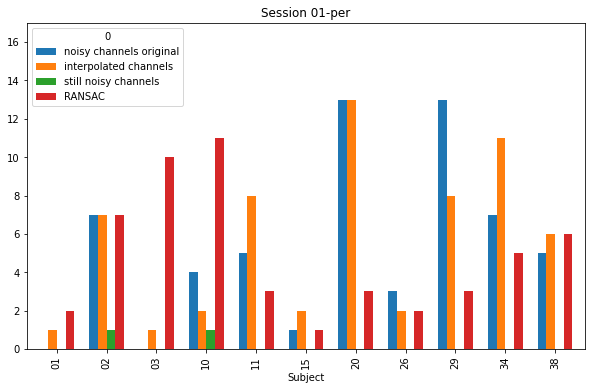

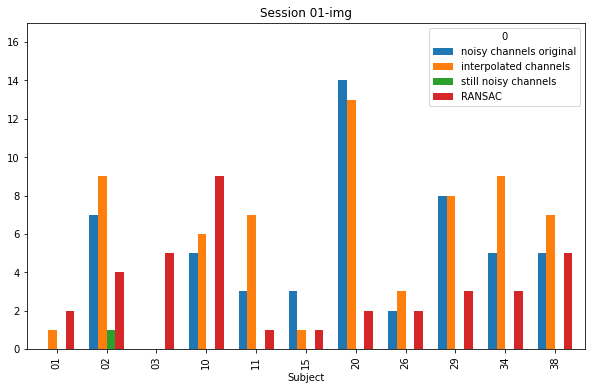

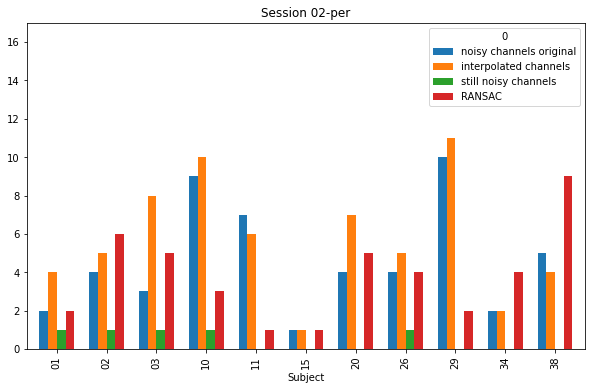

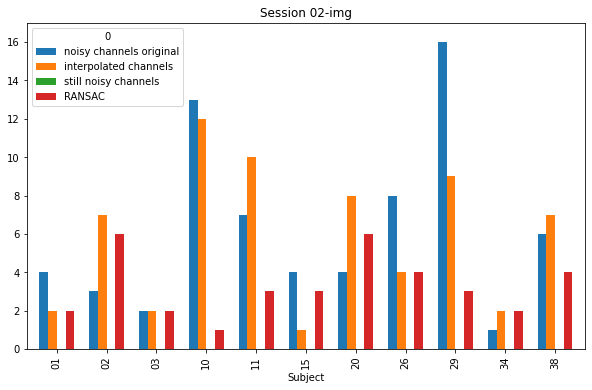

In [ ]:
for sesion in sesions:
  for task in tasks:
    df = df_bar[(df_bar['Sesion'] == sesion) & (df_bar['Task'] == task)]
    df.iloc[:,0:-2].plot(kind = 'bar', title='Session '+ sesion + '-' + task,
                           width = 0.7,figsize=(10,6), ylim=(0,17));
    plt.savefig(trainDir_Raw+'/Ses'+sesion+'_'+task+'.png')

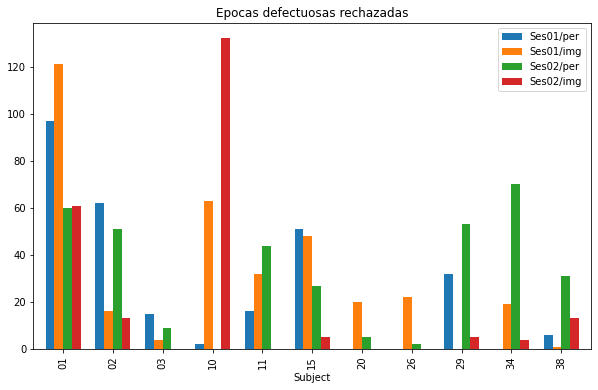

In [ ]:
df_epoch.plot(kind = 'bar', title='Epocas defectuosas rechazadas',
                           width = 0.7,figsize=(10,6));
plt.savefig(trainDir_Raw+'/Bad_Epochs_Autoreject.png')

In [ ]:
boolar = info_autoreject.reshape(1)[0].get('Bad_epochs')
np.count_nonzero(boolar)

13

In [ ]:
df_bar['Total'] = df_bar.iloc[:,[1,2]].sum(axis=1)
df_bar['Ses-Task'] = df_bar.loc[:,['Sesion','Task']].sum(axis=1)

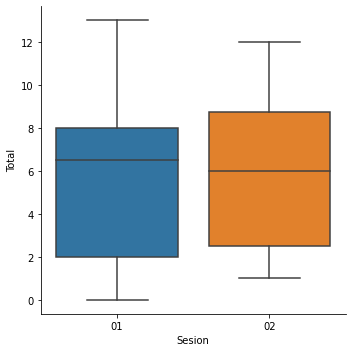

In [ ]:
sn.catplot(x="Sesion", y="Total", kind="box", data=df_bar)

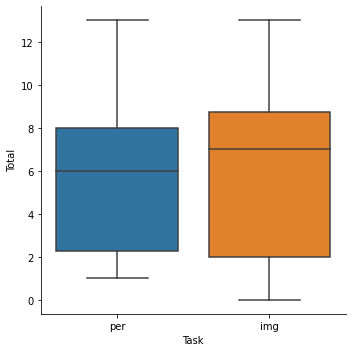

In [ ]:
sn.catplot(x="Task", y="Total", kind="box", data=df_bar)

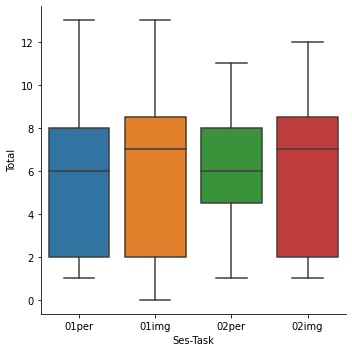

In [ ]:
sn.catplot(x="Ses-Task", y="Total", kind="box", data=df_bar)

In [ ]:
df_epoch_T = df_epoch.T
#df_epoch_T['Total'] = df_epoch_T.sum(axis=1)
df_epoch_T['Ses-Task'] = df_epoch_T.index
df_epoch_T
df_epoch2 = pd.melt(df_epoch_T, id_vars=['Ses-Task'], value_name='Cantidad')

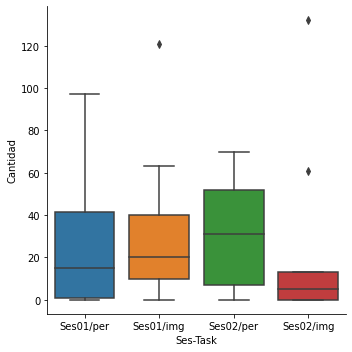

In [ ]:
sn.catplot(x="Ses-Task", y="Cantidad", kind="box", data=df_epoch2)

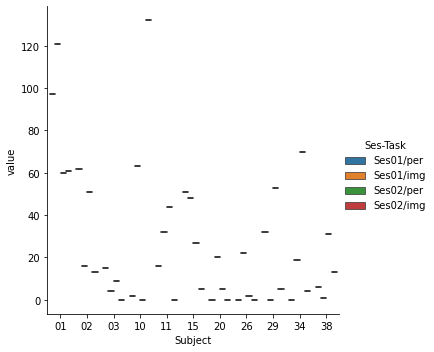

In [ ]:
sn.catplot(x="Subject", y="value", hue="Ses-Task", kind="box", data=df_epoch2)

In [ ]:
info = info_prep[0]
info

{'bad_before_interpolation': ['F2', 'Fp2', 'FT7', 'Fp1', 'P6'],
 'interpolated_channels': ['F2', 'Fp2', 'FT7', 'Fp1', 'P6'],
 'noisy_channels_original': {'bad_all': ['F2', 'AFz', 'AF4', 'F4', 'Fp1'],
  'bad_by_correlation': ['Fp1', 'F4', 'AFz', 'F2', 'AF4'],
  'bad_by_deviation': [],
  'bad_by_flat': [],
  'bad_by_hf_noise': [],
  'bad_by_nan': [],
  'bad_by_ransac': []},
 'still_noisy_channels': []}

# SNR sujetos

In [ ]:
from mne.time_frequency import tfr_morlet, psd_multitaper, psd_welch
baseDir_Raw = '/content/drive/My Drive/TG - Christian Camilo Rosero/Dataset_descargados/OSF_Storage/RawData/'
trainDir_Raw = '/content/drive/My Drive/TG - Christian Camilo Rosero/Codigo/OSF_Storage(1)/RawData/'
baseDir_Preproc = '/content/drive/My Drive/TG - Christian Camilo Rosero/Dataset_descargados/OSF_Storage/PreprocData/'

# subjects = ['02','26','29']
subjects = ['01','02','03','10','11','15','20','26','29','34','38']
sesions = ['01','02']
tasks = ['per','img']

SNR = {}

for subject in subjects:
  snr_raw_per,snr_prepoc_per,snr_raw_img,snr_prepoc_img = [],[],[],[]
  for sesion in sesions:
    for task in tasks:
      print('\n')
      print('subj' + subject + '/' + 'ses' + sesion + '/' + task)
      path_raw_file = baseDir_Raw + 'subj' + subject + '/' + 'ses' + sesion + '/' + task + '/'
      path_raw_train = trainDir_Raw + 'subj' + subject + '/' + 'ses' + sesion + '/' + task + '/'
      path_raw_augmentation = trainDir_Raw + 'subj' + subject + '/' + 'ses' + sesion + '/' + task + '/Augmentation/'

      event_dict= {'New Segment/': 99999, 'Manzana': 11, 'Zanahoria': 12, 'Rosa': 13, 'Mariposa': 21, 'Pollo': 22, 'Oveja': 23, 'Coche': 31, 'Silla': 32, 'Violin': 33, 'Oreja': 41, 'Ojo': 42, 'Mano': 43, 'Catch_trial': 88}

      eeg_raw, Fs, events = extract_raw(path=baseDir_Raw, subject=subject, sesion=sesion, task=task, event_id=event_dict)
      event_dict= {'Manzana': 11, 'Zanahoria': 12, 'Rosa': 13, 'Mariposa': 21, 'Pollo': 22, 'Oveja': 23, 'Coche': 31, 'Silla': 32, 'Violin': 33, 'Oreja': 41, 'Ojo': 42, 'Mano': 43}
      
      #Epoch not preprocesing
      epochs_raw, events_raw= extract_epochs(raw=eeg_raw, event_dict=event_dict, task=task,repair=False)

      #Load epoch preprocesing
      epochs_preproc = mne.read_epochs(path_raw_train +'epochs-epo.fif', preload=True, proj=False)
      events_preproc = np.load(path_raw_train +'events.npy')

      snr_raw,snr_prepoc = SNR_1(epochs_raw, epochs_preproc, task)

      if task is 'per':
        snr_raw_per.append(snr_raw)
        snr_prepoc_per.append(snr_prepoc)
      if task is 'img':
        snr_raw_img.append(snr_raw)
        snr_prepoc_img.append(snr_prepoc)
    
  snr_raw_per = np.mean(np.array(snr_raw_per),axis=0)
  snr_raw_img = np.mean(np.array(snr_raw_img),axis=0)
  snr_prepoc_per = np.mean(np.array(snr_prepoc_per),axis=0)
  snr_prepoc_img = np.mean(np.array(snr_prepoc_img),axis=0)
  
  snr_subject = np.concatenate((snr_raw_per,snr_prepoc_per,snr_raw_img,snr_prepoc_img))
  SNR.setdefault(subject,snr_subject)
columns = ['Alpha Raw Per','Theta Raw Per','Low Beta Raw Per','High Beta Raw Per',
           'Alpha Prepoc Per','Theta Prepoc Per','Low Beta Prepoc Per','High Beta Prepoc Per',
           'Alpha Raw Img','Theta Raw Img','Low Beta Raw Img','High Beta Raw Img',
           'Alpha Prepoc Img','Theta Prepoc Img','Low Beta Prepoc Img','High Beta Prepoc Img']
SNR = pd.DataFrame.from_dict(SNR, orient='index', columns=columns)
SNR.to_csv(trainDir_Raw +'SNR', index=False)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
SNR.to_csv(trainDir_Raw +'SNR', index=False)

In [ ]:
# SNR = pd.read_csv(trainDir_Raw +'SNR')
# SNR = SNR.round(decimals=3)
SNR = SNR.set_index(0)
SNR = SNR.rename_axis('Subject')
#SNR.to_csv(trainDir_Raw +'SNR', index=False)
SNR

,Alpha Raw Per,Theta Raw Per,Low Beta Raw Per,High Beta Raw Per,Alpha Prepoc Per,Theta Prepoc Per,Low Beta Prepoc Per,High Beta Prepoc Per,Alpha Raw Img,Theta Raw Img,Low Beta Raw Img,High Beta Raw Img,Alpha Prepoc Img,Theta Prepoc Img,Low Beta Prepoc Img,High Beta Prepoc Img
Subject,,,,,,,,,,,,,,,,
0,0.300,0.173,0.037,0.015,1.283,0.732,0.233,0.114,0.068,0.034,0.016,0.015,0.131,0.045,0.021,0.022
1,0.144,0.107,0.061,0.034,0.498,0.517,0.120,0.088,0.186,0.085,0.044,0.033,0.050,0.041,0.030,0.038
2,0.069,0.083,0.018,0.016,0.427,0.184,0.073,0.089,0.034,0.017,0.015,0.013,0.059,0.018,0.016,0.019
3,0.196,0.076,0.029,0.014,0.868,0.515,0.157,0.079,0.097,0.030,0.019,0.013,0.063,0.027,0.021,0.021
4,0.220,0.164,0.042,0.024,1.256,0.893,0.185,0.110,0.109,0.056,0.027,0.015,0.040,0.022,0.018,0.017
5,0.084,0.043,0.016,0.016,0.983,0.450,0.103,0.082,0.069,0.027,0.015,0.011,0.048,0.021,0.016,0.016
6,0.242,0.106,0.038,0.022,1.163,0.515,0.140,0.104,0.084,0.057,0.024,0.024,0.151,0.043,0.028,0.028
7,0.081,0.074,0.033,0.028,0.670,0.282,0.126,0.151,0.043,0.033,0.014,0.012,0.045,0.021,0.017,0.017
8,0.070,0.050,0.023,0.017,0.604,0.271,0.089,0.086,0.054,0.026,0.019,0.016,0.102,0.025,0.019,0.020


# **Completo TRF Sujetos**

In [ ]:
baseDir_Raw = '/content/drive/My Drive/TG - Christian Camilo Rosero/Dataset_descargados/OSF_Storage/RawData/'
trainDir_Raw = '/content/drive/My Drive/TG - Christian Camilo Rosero/Codigo/OSF_Storage(1)/RawData/'
baseDir_Preproc = '/content/drive/My Drive/TG - Christian Camilo Rosero/Dataset_descargados/OSF_Storage/PreprocData/'

subjects = ['01','02','03','10','11']
sesions = ['01','02']
tasks = ['per','img']

for subject in subjects:
  for sesion in sesions:
    for task in tasks:
      print('\n')
      print('subj' + subject + '/' + 'ses' + sesion + '/' + task)
      path_raw_file = baseDir_Raw + 'subj' + subject + '/' + 'ses' + sesion + '/' + task + '/'
      path_raw_train = trainDir_Raw + 'subj' + subject + '/' + 'ses' + sesion + '/' + task + '/'

      event_dict= {'Manzana': 11, 'Zanahoria': 12, 'Rosa': 13, 'Mariposa': 21, 'Pollo': 22, 'Oveja': 23, 'Coche': 
                   31, 'Silla': 32, 'Violin': 33, 'Oreja': 41, 'Ojo': 42, 'Mano': 43}
      #Load
      epochs = mne.read_epochs(path_raw_train +'epochs-epo.fif', preload=True)
      events = np.load(path_raw_train +'events.npy')

      # trf
      tfr(epochs,events,event_id=event_dict, n_cycles=4, window = 0.6, path=path_raw_train, plot=True)
      del epochs
      gc.collect()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
baseDir_Raw = '/content/drive/My Drive/TG - Christian Camilo Rosero/Dataset_descargados/OSF_Storage/RawData/'
trainDir_Raw = '/content/drive/My Drive/TG - Christian Camilo Rosero/Codigo/OSF_Storage(1)/RawData/'
baseDir_Preproc = '/content/drive/My Drive/TG - Christian Camilo Rosero/Dataset_descargados/OSF_Storage/PreprocData/'

subjects = ['15','20','26','29']
sesions = ['01','02']
tasks = ['per','img']

for subject in subjects:
  for sesion in sesions:
    for task in tasks:
      print('\n')
      print('subj' + subject + '/' + 'ses' + sesion + '/' + task)
      path_raw_file = baseDir_Raw + 'subj' + subject + '/' + 'ses' + sesion + '/' + task + '/'
      path_raw_train = trainDir_Raw + 'subj' + subject + '/' + 'ses' + sesion + '/' + task + '/'

      event_dict= {'Manzana': 11, 'Zanahoria': 12, 'Rosa': 13, 'Mariposa': 21, 'Pollo': 22, 'Oveja': 23, 'Coche': 
                   31, 'Silla': 32, 'Violin': 33, 'Oreja': 41, 'Ojo': 42, 'Mano': 43}
      #Load
      epochs = mne.read_epochs(path_raw_train +'epochs-epo.fif', preload=True)
      events = np.load(path_raw_train +'events.npy')

      # trf
      tfr(epochs,events,event_id=event_dict, n_cycles=4, window = 0.6, path=path_raw_train, plot=True)
      del epochs
      gc.collect()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
baseDir_Raw = '/content/drive/My Drive/TG - Christian Camilo Rosero/Dataset_descargados/OSF_Storage/RawData/'
trainDir_Raw = '/content/drive/My Drive/TG - Christian Camilo Rosero/Codigo/OSF_Storage(1)/RawData/'
baseDir_Preproc = '/content/drive/My Drive/TG - Christian Camilo Rosero/Dataset_descargados/OSF_Storage/PreprocData/'

subjects = ['34','38']
sesions = ['01','02']
tasks = ['per','img']

for subject in subjects:
  for sesion in sesions:
    for task in tasks:
      print('\n')
      print('subj' + subject + '/' + 'ses' + sesion + '/' + task)
      path_raw_file = baseDir_Raw + 'subj' + subject + '/' + 'ses' + sesion + '/' + task + '/'
      path_raw_train = trainDir_Raw + 'subj' + subject + '/' + 'ses' + sesion + '/' + task + '/'

      event_dict= {'Manzana': 11, 'Zanahoria': 12, 'Rosa': 13, 'Mariposa': 21, 'Pollo': 22, 'Oveja': 23, 'Coche': 
                   31, 'Silla': 32, 'Violin': 33, 'Oreja': 41, 'Ojo': 42, 'Mano': 43}
      #Load
      epochs = mne.read_epochs(path_raw_train +'epochs-epo.fif', preload=True)
      events = np.load(path_raw_train +'events.npy')

      # trf
      tfr(epochs,events,event_id=event_dict, n_cycles=4, window = 0.6, path=path_raw_train, plot=True)
      del epochs
      gc.collect()

Output hidden; open in https://colab.research.google.com to view.

# **DATOS PREPROCESADOS**

Con los subjetos, para ambas sesiones, ambas tareas pero con datos preprocesados

In [ ]:
baseDir_Raw = '/content/drive/My Drive/TG - Christian Camilo Rosero/Dataset_descargados/OSF_Storage/RawData/'
baseDir_Preproc = '/content/drive/My Drive/TG - Christian Camilo Rosero/Dataset_descargados/OSF_Storage/PreprocData/'
trainDir_Preproc = '/content/drive/My Drive/TG - Christian Camilo Rosero/Codigo/OSF_Storage(1)/PreprocData/'

subjects = ['01']
tasks = ['img']

for subject in subjects:
  for task in tasks:
    print('\n')
    print('subj' + subject + '/' + task)
    path_preproc_file = baseDir_Preproc + 'subj' + subject + '/' + task + '.mat'
    path_preproc_train = trainDir_Preproc + 'subj' + subject + '/' + task + '/'
    fname_bad = baseDir_Preproc + 'subj' +  subject + '/' + 'info_channel.mat'
    print(path_preproc_file)
    print(path_preproc_train)

    #Events of Raw original

    event_dict= {'New Segment/': 99999, 'Manzana': 11, 'Zanahoria': 12, 'Rosa': 13, 'Mariposa': 21, 'Pollo': 22, 'Oveja': 23, 'Coche': 31, 'Silla': 32, 'Violin': 33, 'Oreja': 41, 'Ojo': 42, 'Mano': 43, 'Catch_trial': 88}
    eeg_raw, Fs, events_1= extract_raw(path=baseDir_Raw, subject=subject, sesion='01', task=task, event_id=event_dict) # Events of Raw sesion 1
    eeg_raw, Fs, events_2 = extract_raw(path=baseDir_Raw, subject=subject, sesion='02', task=task, event_id=event_dict) # Events of Raw sesion 2

    event_dict= {'Manzana': 11, 'Zanahoria': 12, 'Rosa': 13, 'Mariposa': 21, 'Pollo': 22, 'Oveja': 23, 'Coche': 31, 'Silla': 32, 'Violin': 33, 'Oreja': 41, 'Ojo': 42, 'Mano': 43}
    epochs, events = extract_epochs_preproc(path_preproc_file, fname_bad, eeg_raw, events_1 = events_1, events_2=events_2, event_dict=event_dict, task=task, Fs=250)
    del eeg_raw
    #tfr(epochs=epochs, events=events,event_id=event_dict, n_cycles=2, window = 0.6, path=path_preproc_train, plot=True, grafic_trf=False)



   
    # #epochs = mne.read_epochs_fieldtrip(path_preproc_file, original_info, data_name='data')
    # event_dict= {'Manzana': 11, 'Zanahoria': 12, 'Rosa': 13, 'Mariposa': 21, 'Pollo': 22, 'Oveja': 23, 'Coche': 31, 'Silla': 32, 'Violin': 33, 'Oreja': 41, 'Ojo': 42, 'Mano': 43}
    # epochs = extract_epochs(raw=eeg_raw, events=events, event_dict=event_dict, task=task)
    # #eeg_raw = Repairing_EOG_artifacts(raw=eeg_raw, components=4, algoritme='ICA')
    # #eeg_raw = Repairing_EOG_artifacts(raw=eeg_raw, components=4)
    # post_epochs = extract_epochs(raw=eeg_raw, events=events, event_dict=event_dict, task=task)
    # del eeg_raw
    # eeg_raw, Fs, events, event_dict = extract_raw(path=baseDir_Raw, subject=subject, sesion='01', task=task, event_id=event_dict)
    # original_info = eeg_raw.info
    # del eeg_raw